<a href="https://colab.research.google.com/github/jjordana/twitter_sentiment_analysis/blob/master/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **EDA**

# Set-Up


## Kaggle's API

In [60]:
!pip install -q kaggle
!mkdir .kaggle

mkdir: cannot create directory ‘.kaggle’: File exists


In [0]:
import json
token = {"username":"jjordana16","key":"6e806145f7c3fdd4c09e7299f3a70d73"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [62]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v/content

- path is now set to: /content


In [63]:
!kaggle competitions download -c tweet-sentiment-extraction

test.csv: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


## Importing Libraries & data

In [64]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

import os
import re
import random
import re, string
import time

from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet') # For the counterPlots

## Used for creating the words graphs
from collections import defaultdict
import plotly.graph_objs as go
from plotly import tools
import plotly.offline as py

# Listing all the files in our folder
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
test = pd.read_csv('/content/competitions/tweet-sentiment-extraction/test.csv')
train = pd.read_csv('/content/competitions/tweet-sentiment-extraction/train.csv.zip')

# EDA

Before starting our analysis, we have to check that there is not `null` data. Besides, we must remove duplicate data, as we do not need it.

In [66]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [118]:
train = train.dropna()
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB


In [120]:
duplicate_indices = train.loc[train.duplicated(keep='first')].index

print('Number of duplicates in the dataset: {}'.format(train.loc[duplicate_indices, 'text'].count()))
train.loc[duplicate_indices, :].sort_values(by=['text']).head()

# train_data.drop_duplicates(keep='first', inplace=True)

Number of duplicates in the dataset: 0


,textID,text,selected_text,sentiment


In [121]:
duplicate_indices = test.loc[test.duplicated(keep='first')].index

print('Number of duplicates in the dataset: {}'.format(test.loc[duplicate_indices, 'text'].count()))
test.loc[duplicate_indices, :].sort_values(by=['text']).head()

Number of duplicates in the dataset: 0


,textID,text,sentiment


In [126]:
print('TRAIN LENGTH ', len(train))
print('TEST LENGTH ', len(test))

TRAIN LENGTH  27480
TEST LENGTH  3534


In this notebook our main target is going to be the analysis of all our tweets data. We are going to focus (basically) on the `training set`.<br>

We have distinguish three types of sentiments: `positive`, `neutral`, and `negative`. <br> The main aim of this [Kaggle's competition](https://www.kaggle.com/c/tweet-sentiment-extraction) is to get the words that have the highest weight for deciding the sentiment of a tweet. Therefore, the sentiment has already been stablished, we do not need to get it.<br>
However, it's important to understand how `sentiment analysis` works before going on a further level.

In our `training data`, `neutral` tweets are the most common ones, followed by `positive` and `negative` tweets.

neutral     11117
positive     8582
negative     7781
Name: sentiment, dtype: int64


Text(0.5, 1.0, 'Train Sentiment Count')

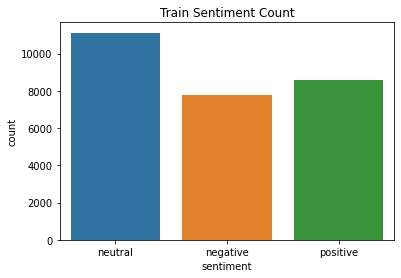

In [122]:
sentiments = ['positive', 'neutral', 'negative']
print(train['sentiment'].value_counts())
sns.countplot(x='sentiment', data=train).set_title('Train Sentiment Count')

Great. Neutral tweets are the most common in our data.<br>

Tweets are the result of a set of elements. They can contain words, links, user-names...so many things!! <br>
The `selected_text` column has all the target words. It would be great to have some idea about which are the most common words in our dataset. 

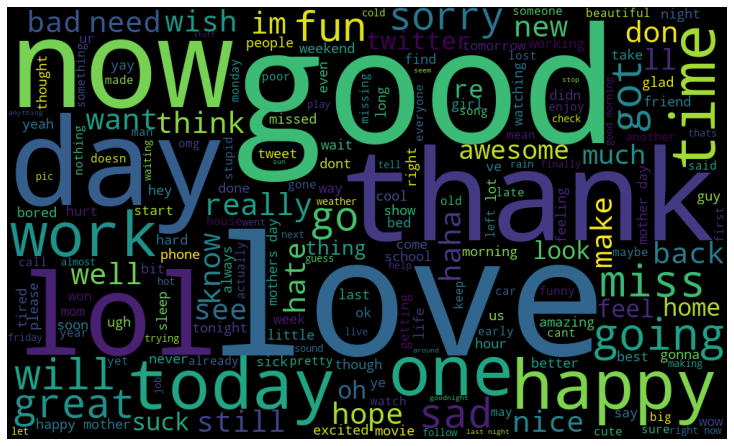

In [69]:
comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in train['selected_text']: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 1000, height = 600, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (10, 6), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

Words such as _love, good, thank_ seem to be the most common in all our data (those are the biggest ones and in a wordcloud plot big means more). However, trying to plot a `worcloud` with all the *selected_text* is useless. It is more acurrate to work separetly with all the different sentiments. 

We can split our oirginal dataste into three subdatasets, differentiated by the sentiment. <br> After having all the data splitted we can now study sentiment by sentiment.

NPL processes deal with text chains. This chains need to be trasnformed. <br> Firstly, we are going to split our tweets into `tokens`, sets of words. After this, `lemmatization`much be the following step. In this part, we will get the root of the word _(i.e the root for **player** is play)_.

But, before performing any of these steps, we must **clean** firstly our data. I consider this part the most important one. <br> Keep in mind that we are dealing with **tweets**!! Here anyone can write in any particular way. There are no rules. For sure our texts are full of special character `[?!,:),:(&]`, links and so on. We need to try to homogenize our data as much as possible.<br>
Besides, we are going to try to solve those spelling imperfections such as _heeeeello_. Here, you can see that the letter **e** is repeated several times. Although we know that means __hello__, the code is going to treat it as a different word. We will try to fix this by trying to replace any `vocal` or common letter (i.e `n, r, s, l`) that is repeated more than three time.


In [0]:
def cleaningText(df, column):
  # Removing special characters
  for val in map(lambda r: re.compile(re.escape(r)), [",", ":", "\"", "=", "&", 
    ";", "%", "$", "@", "%", "^", "*", "(", ")", "{", "}", "[", "]", "|", "/", 
    "\\", ">", "<", "-", "!", "?", ".", "'", "_", "--", "---", "#"]):
    df[column] = df[column].str.replace(re.compile(val), "")

  # Removing urls
  df[column] = df[column].replace('http\S[a-z0-9]+', '', regex=True)

  return df

In [0]:
 # Removing repeated letters
def controlLetters(x):
    text = x
    for letter in ['a', 'e', 'i', 'o', 'u', 'r', 'l', 'n', 's', 'm']:
    # for letter in ['e', 'l', 'o']:
        key = str(letter*3) + '+'
        if len(re.findall(key, text)) > 0:
            text = re.sub((str(letter*3) + '+'), letter, text)
        
    return text
  

In [0]:
# For the tweet text
train['newText'] = train['text'].str.lower()
train = cleaningText(train, 'newText')
train['newText'] = train['newText'].apply(controlLetters)

# For the selected_text
train['newSelection'] = train['selected_text'].str.lower()
train = cleaningText(train, 'newSelection')
train['newSelection'] = train['newSelection'].apply(controlLetters)

Now that we have cleaned our text, lets perform our tokenization and lemmatization.<br>
We will plot all our data so we can understand easily the top words.

In [0]:
def tokenization(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    myToken = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(val) for val in myToken]

lemmatizer = WordNetLemmatizer()

def lemmatization(tokens):
    lemmatized_words = []
    for val in tokens:
        val = lemmatizer.lemmatize(val,pos ="a")
        val = lemmatizer.lemmatize(val,pos ="n")
        val = lemmatizer.lemmatize(val,pos ="v")
        lemmatized_words.append(val)
    return lemmatized_words

In [74]:
def counterPlot(df, columns):
  # Creating the Chart
  def horizontal_bar_chart(df, color):
      trace = go.Bar(
          y=df["word"].values[::-1],
          x=df["wordcount"].values[::-1],
          showlegend=False,
          orientation = 'h',
          marker=dict(color=color, ),)
      return trace

  result = []
  dictio = []
  for val in range(0, 3):
    freq_dict = defaultdict(int)
    for tweet in df[df['sentiment']==columns[val]]['newSelection']:
        for word in lemmatization(tokenization(tweet)):
            freq_dict[word] += 1

    colors = ['green', 'orange', 'red']
    # Building graph for our dictionary
    df_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
    df_sorted.columns = ["word", "wordcount"]
    trace = horizontal_bar_chart(df_sorted.head(50), colors[val])
    result.append(trace)
    dictio.append(freq_dict)

  # Creating two subplots
  fig = tools.make_subplots(rows=1, cols=3, vertical_spacing=0.04,
                          subplot_titles=["Positive frequent words", 'Neutral frequent words', 'Negative frequent words'])
  
  i = 1
  for val in result:
    fig.append_trace(val, 1, i)
    i += 1

  fig['layout'].update(height=1000, width=900, paper_bgcolor='rgb(233,233,233)', title="TOP WORDS")

  return py.iplot(fig, filename='word-plots'), dictio

wordList = counterPlot(train, sentiments)
wordList[0]

In [0]:
# Provides de TOP 50 words for specific sentiment
def sentimentTopWords(sentiment):
  val = sentiments.index(sentiment)

  df = pd.DataFrame.from_dict(wordList[1][val], orient='index')
  df['word'] = df.index
  df['count'] = df[0]
  df = df.reset_index().drop(columns=[0, 'index']).sort_values(by='count', ascending=False).head(120)
  return list(df['word'])

In [0]:
! pip install matplotlib-venn-wordcloud

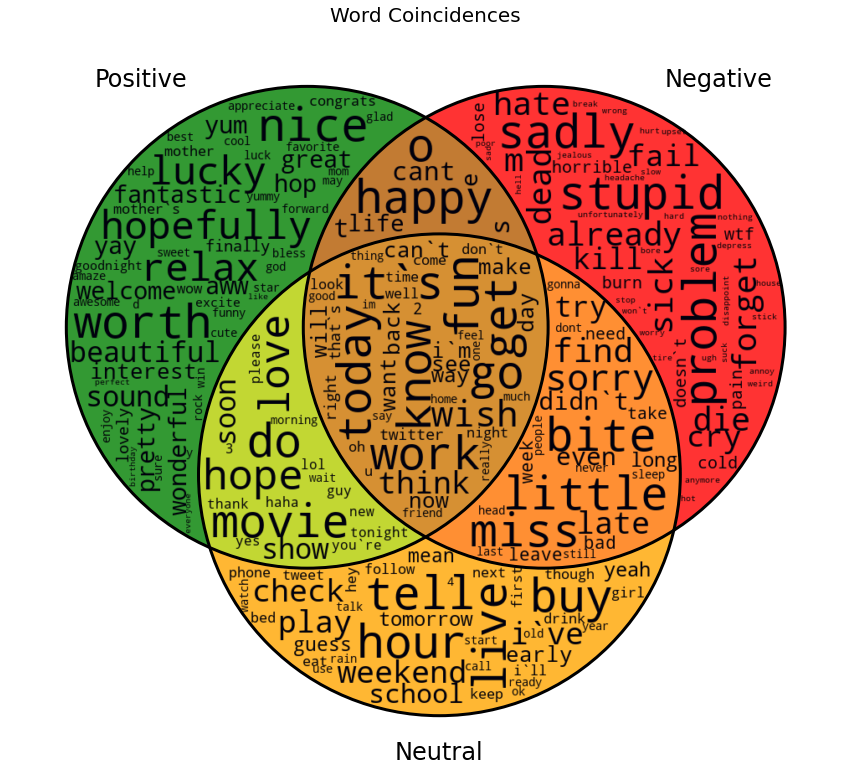

In [77]:
from matplotlib_venn_wordcloud import venn3_wordcloud

fig, ax = plt.subplots(figsize = (15,15))
ax.set_title('Word Coincidences', fontsize=20)
v = venn3_wordcloud([set(sentimentTopWords('positive')), set(sentimentTopWords('negative')), set(sentimentTopWords('neutral'))],
          set_labels=['Positive', 'Negative', 'Neutral'], ax=ax, set_colors=['green', 'red', 'orange'])

Both graphs provides us a good idea about which are the words most repeated for each sentiment, and which of them are common between different sentiments. Obvisouly, those words that belong to a specific sentiment are always going to be less _problematic_ than those mixed, as they will be classified directly.

Now we have some idea about which are the most common words between sentiments. Let's focus on the _selected_text_. This column represents our target. Those are the words that after all our process we want to achieve. Let's try to analyze the similartity of _selected_text_ with respect the main tweet (we will analyze our `newSelection` as it has been already tokenized and lemmatized). This calculus is called [`jaccard similarity`](https://deepai.org/machine-learning-glossary-and-terms/jaccard-index), and I found it very interesting on [Mr_KnowNothing's kernell](https://www.kaggle.com/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model).<br>
*Just remember that since we have tokenize and lemmatice our data, the reference columns that we are using are __newText__ and __newSelection__*


In [0]:
def jaccardScore(a, b):
  a = lemmatization(tokenization(a))
  b = lemmatization(tokenization(b))
  
  try:
    intersect = list(set(a).intersection(b)) # Common values between A and B
    union = len(a) + len(b) - len(intersect) # Values of A and B witout commons
    return round((len(intersect) / union), 2)
  except: # For those cases in which our tweet is mainly composed of STOPWORDS
    return 1

In [0]:
train['jaccScore'] = train.apply(lambda x: jaccardScore(x.newText, x.newSelection), axis=1)

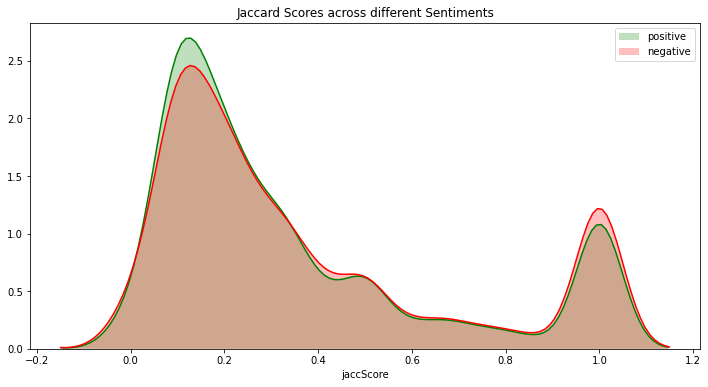

In [80]:
plt.figure(figsize=(12,6))
p1=sns.distplot(train[train['sentiment']=='positive']['jaccScore'], kde_kws={"shade": True}, color="g", hist=False).set_title('Jaccard Scores across different Sentiments')
p2=sns.distplot(train[train['sentiment']=='negative']['jaccScore'], kde_kws={"shade": True}, color="r", hist=False)

plt.legend(labels=['positive','negative'])

We have only focused on `positive` and `negative` sentiments because the majority of neutral tweet have either a lot of difference or lot of similarity (the are not intermediate values and therefore the scale does not help to visualize the data).

Understanding the `jaccard scores graph`, we can conclude that both _positive_ and _negative_ sentiments behave similar. Basically, the majority of the tweets have just a few words in their sentiment `selected_text`. There are only a few of them that have all the tweet's text.

Let's keep analyzing our data.<br>
After reading [Radoslawkrolikowski's repository](https://https://github.com/radoslawkrolikowski/sentiment-analysis-pytorch/blob/master/1_data_processing.ipynb) I have found interesting to add certain parameters performing a new `feature engineering`. These parameters are:<br>
`Polarity Score`: calculates a score for describing weather the sentiment of the tweet is negative (-1), netural (0) or positive (+1).<br>
`Subjectivity`: a float that indicates weather the tweet is objective (0) or subjective (1).

In [0]:
def polarity(text):
    return TextBlob(text).sentiment.polarity

def subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

In [0]:
train['polarityScore'] = train['newText'].apply(polarity)
train['subjectivity'] = train['newText'].apply(subjectivity)

test['polarityScore'] = test['newText'].apply(polarity)
test['subjectivity'] = test['newText'].apply(subjectivity)

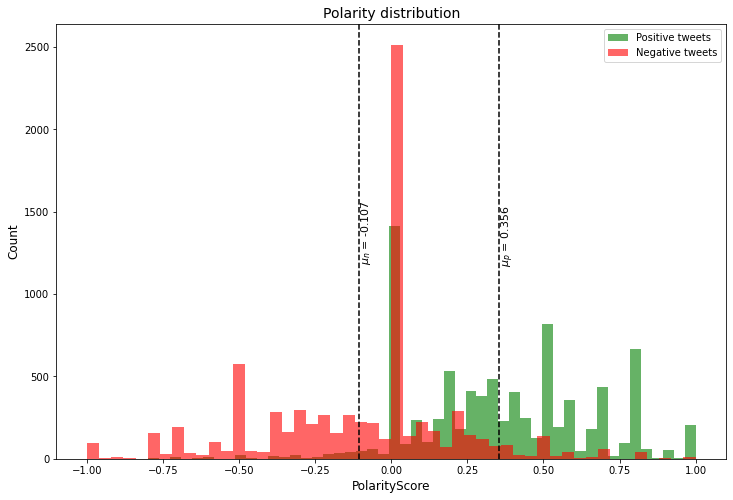

In [129]:
# Create a new figure
plt.figure(figsize=(12,8))

# Create a histogram of polarity 
plt.hist(train[train['sentiment'] == 'positive']['polarityScore'], bins=50, label='Positive tweets', alpha=0.6, color='green')
plt.hist(train[train['sentiment'] == 'negative']['polarityScore'], bins=50, label='Negative tweets', alpha=0.6, color='red')
# plt.hist(train[train['sentiment'] == 1]['polarityScore'], bins=50, label='Neutral tweets', alpha=0.6, color='orange')

# Create the title, horizontal axis label, vertical axis label and legend for the histograms
plt.title('Polarity distribution', size=14)
plt.xlabel('PolarityScore', size=12)
plt.ylabel('Count', size=12)
plt.legend(loc='upper right')

# Calculate the mean value of polarity for positive and negative reviews
positiveMean = train[train['sentiment'] == 'positive']['polarityScore'].mean()
negativeMean = train[train['sentiment'] == 'negative']['polarityScore'].mean()
# neutralMean = train[train['sentiment'] == 1]['polarityScore'].mean()

# Add vertical lines that represent the average polarity of each class
plt.axvline(positiveMean, c='k', linestyle='--', linewidth=1.5)
plt.axvline(negativeMean, c='k', linestyle='--', linewidth=1.5)
# plt.axvline(neutralMean, c='k', linestyle='--', linewidth=1.5)

# Add annotations
plt.text(positiveMean, 1200, r'$\mu_p$ = {:.3f}'.format(positiveMean), rotation=90, size=11)
plt.text(negativeMean, 1200, r'$\mu_n$ = {:.3f}'.format(negativeMean), rotation=90, size=11)
# plt.text(neutralMean, 1200, r'$\mu_n$ = {:.3f}'.format(neutralMean), rotation=90, size=11)

plt.show()

Most of the tweets selected text seem to have `polarity=0`. <br>
The shadow represents that there is more common for negative tweets to have positive polarity than for positive tweets to have negative.<br>
For sure, this will give us some problems.

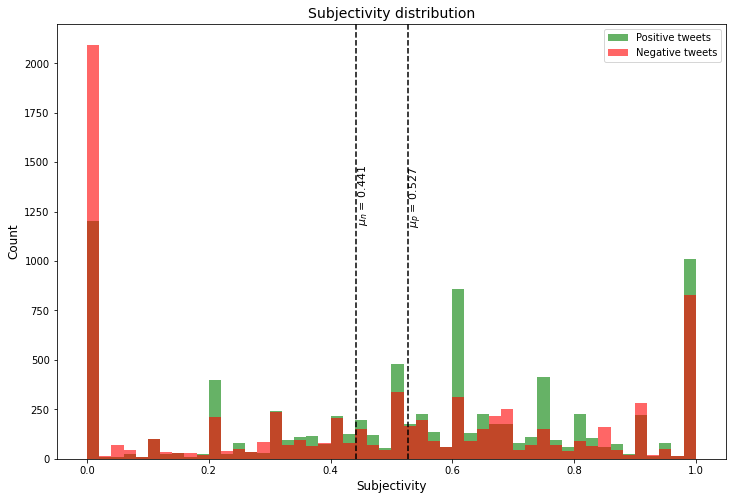

In [131]:
# Create a new figure
plt.figure(figsize=(12,8))

# Create a histogram of polarity 
plt.hist(train[train['sentiment'] == 'positive']['subjectivity'], bins=50, label='Positive tweets', alpha=0.6, color='green')
plt.hist(train[train['sentiment'] == 'negative']['subjectivity'], bins=50, label='Negative tweets', alpha=0.6, color='red')
# plt.hist(train[train['sentiment'] == 1]['polarityScore'], bins=50, label='Neutral tweets', alpha=0.6, color='orange')

# Create the title, horizontal axis label, vertical axis label and legend for the histograms
plt.title('Subjectivity distribution', size=14)
plt.xlabel('Subjectivity', size=12)
plt.ylabel('Count', size=12)
plt.legend(loc='upper right')

# Calculate the mean value of polarity for positive and negative reviews
positiveMean = train[train['sentiment'] == 'positive']['subjectivity'].mean()
negativeMean = train[train['sentiment'] == 'negative']['subjectivity'].mean()
# neutralMean = train[train['sentiment'] == 1]['polarityScore'].mean()

# Add vertical lines that represent the average polarity of each class
plt.axvline(positiveMean, c='k', linestyle='--', linewidth=1.5)
plt.axvline(negativeMean, c='k', linestyle='--', linewidth=1.5)
# plt.axvline(neutralMean, c='k', linestyle='--', linewidth=1.5)

# Add annotations
plt.text(positiveMean, 1200, r'$\mu_p$ = {:.3f}'.format(positiveMean), rotation=90, size=11)
plt.text(negativeMean, 1200, r'$\mu_n$ = {:.3f}'.format(negativeMean), rotation=90, size=11)
# plt.text(neutralMean, 1200, r'$\mu_n$ = {:.3f}'.format(neutralMean), rotation=90, size=11)

plt.show()

Subjectivity is an unseful feature. <br>
We can see that it is spread all over the axis. There is not any specific point in which we could say that positive tweet seem to be more subjective thant negative. Therefore, this columns will not be taken into account.

Here we can conclude our explorator data analysis.<br>

After this study, we have a better idea of the most crucial facts of our training data.

# Bibliography

[*I’m going on a (data) adventure! — Hobbit text analysis*](https://towardsdatascience.com/im-going-on-a-data-adventure-hobbit-text-analysis-a0a5cb116ed1)

[*Introduction to Natural Language Processing with the Beatles and Taylor Swift*](https://towardsdatascience.com/introduction-to-natural-language-processing-with-the-beatles-and-taylor-swift-2a06055cbc14)

[*NLTK Library*](https://www.nltk.org/api/nltk.sentiment.html)

[*POLARITY_SCORE example*](https://towardsdatascience.com/almost-real-time-twitter-sentiment-analysis-with-tweep-vader-f88ed5b93b1c)

[*How to perform Sentyment Analysis*](https://www.digitalocean.com/community/tutorials/how-to-perform-sentiment-analysis-in-python-3-using-the-natural-language-toolkit-nltk)

[*Ven diagrams and Wordclouds in Python*](https://towardsdatascience.com/venn-diagrams-and-word-clouds-in-python-1012373b38ed)